In [2]:
'''
Author: tianhao 120090472@link.cuhk.edu.cn
Date: 2023-09-26 09:57:54
LastEditors: tianhao 120090472@link.cuhk.edu.cn
LastEditTime: 2023-09-29 16:22:53
FilePath: /DatProc/misc.ipynb
Description: 
    Code to rebalance Dataset
Copyright (c) 2023 by ${git_name_email}, All Rights Reserved. 
'''
import os
import json
import argparse
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from scipy import stats
from multiprocessing import Pool
from matplotlib import pyplot as plt
from scipy.optimize import minimize

from utils.cam_pose_utils import get_cam_coords

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input_path", type=str, help="path to json metafile", default="/data2/chence/single_view_hq/dataset.json")
    parser.add_argument("-o", "--output_dir", type=str, help="path to output directory", default="./temp")
    parser.add_argument("-j", "--num_workers", type=int, help="number of workers", default=256)
    # parser.add_argument("--force", action="store_true", help="force to overwrite existing files")
    args, _ = parser.parse_known_args()
    return args

def get_coord():
    """
    Load camera position. A npy file is created to save. If operation is forced, the npy file will be overwritten.
    """
    coords_save_path = os.path.join(args.output_dir, "coords.npy")
    coords = []
    if not(hasattr(args, 'force')):
        if os.path.exists(coords_save_path):
            coords = np.load(coords_save_path)

    if isinstance(coords, list):
        print(f'Calculating coords...')
        with open(args.input_path, 'r') as f:
            json_data = json.load(f)
        for img_path, img_meta in tqdm(json_data.items()):
            c2w = np.array(img_meta["camera"][:16]).reshape(4,4)
            theta, phi, r, x, y, z = get_cam_coords(c2w)
            if theta < -90 and theta >= -180: theta += 360
            coords.append((theta, phi))
        coords = np.array(coords)
        np.save(coords_save_path, coords)
    return coords

def get_density(coords: np.array):
    """
    Load density file. A npy file is created to save. If operation is forced, the npy file will be overwritten.
    """
    global kernel
    density_save_path = os.path.join(args.output_dir, "density.npy")
    densities = []
    kernel = stats.gaussian_kde(coords.T)
    if not(hasattr(args, 'force')):
        if os.path.exists(density_save_path):
            densities = np.load(density_save_path)

    if isinstance(densities, list):
        print(f'Calculating density...')
        for coord in tqdm(coords):
            density = kernel(coord)
            densities.append(density)
        densities = np.array(densities)
        print(f'Maximum density: {np.max(densities)}, Minimum density: {np.min(densities)}')
        np.save(density_save_path, densities)
    return densities

def get_num_duplicate(densities: np.array, bin_bounds: np.array, a=0.002):
    N = []
    Z = []
    for density in tqdm(densities):
        if density < bin_bounds[1]:
            _N = len(bin_bounds) - 1
        else:
            _N = min(len(bin_bounds) - 2, max(1, round(a/density)))
        N.append(_N)
        Z.append(density*_N)
    return N, Z

kernel = None
args = parse_args()
with open(args.input_path, 'r') as f:
    json_data = json.load(f)

In [3]:
coords = get_coord()
densities = get_density(coords)
theta = coords[:, 0]
phi = coords[:, 1]
densities_unique, counts = np.unique(densities, return_counts=True)
# cumulative_counts = np.cumsum(counts)
# find_percentiles = [0, 20, 40, 60, 80, 100]
max_density = densities_unique[-1]
max_dup_nums = [8]
colors = ['b', 'g', 'r', 'c']
for max_dup_num, color in zip(max_dup_nums, colors):
    density_bounds = [0] + [max_density / i for i in range(max_dup_num, 0, -1)]


Percntile 0.1=48.8622242653656; -88.98356389359346
Percntile 50=85.22697294296465; 81.01653309689034
Percntile 99.9=115.93806056482318; 268.9493846692784


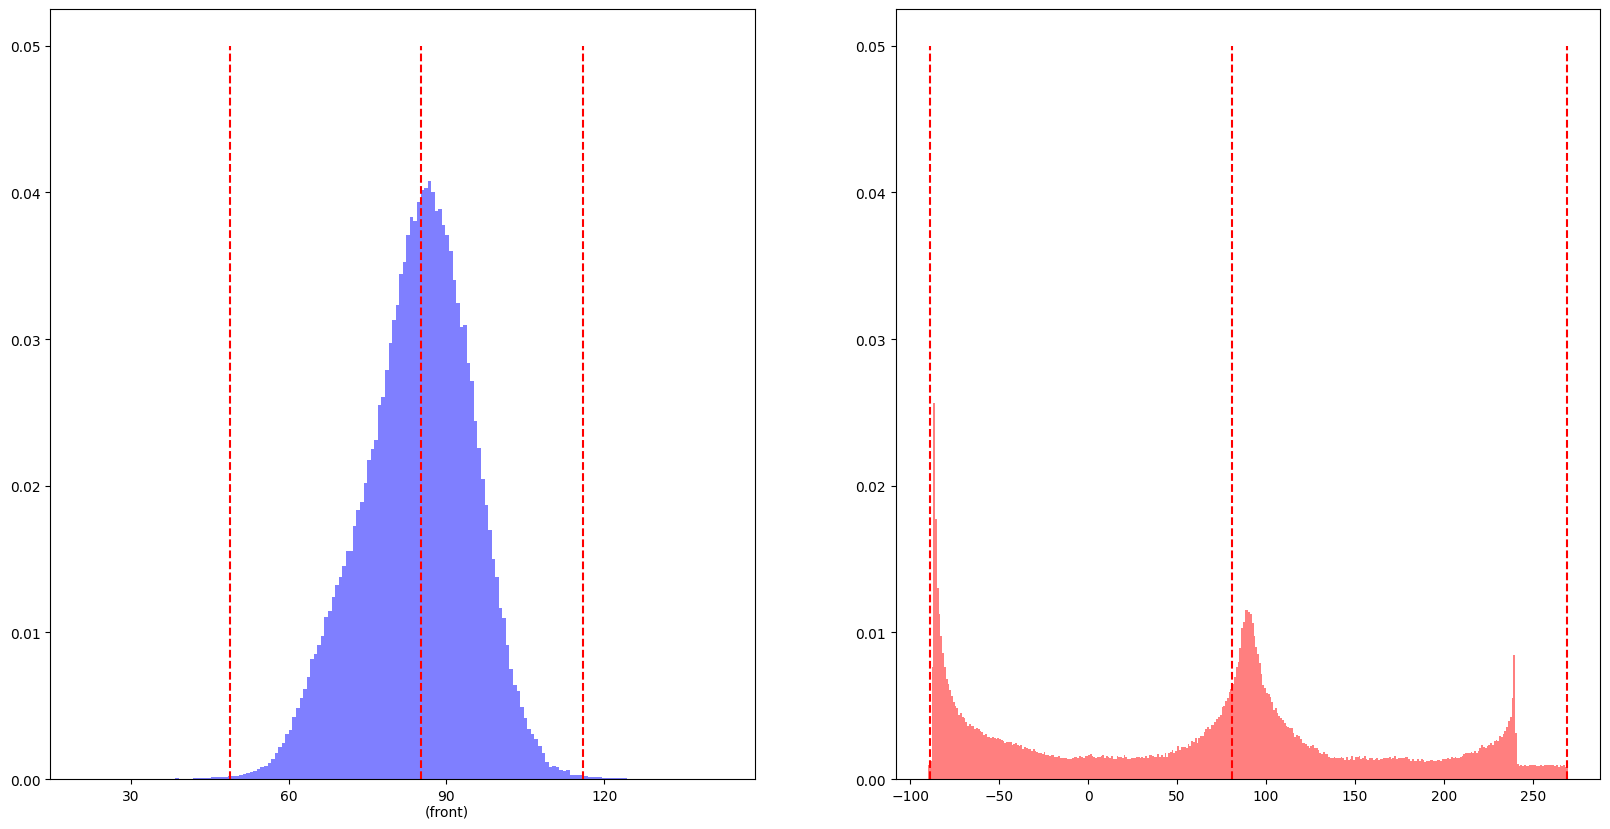

In [4]:
fig, ax5 = plt.subplots(1, 2, figsize=(20, 10))
ax5[0].hist(phi, bins=180, density=True, color='b', alpha=0.5, label=r"$\phi$")
ax5[0].set_xticks(np.arange(0, 181, 30))
ax5[0].set_xticklabels(['0\n(up)', '30', '60', '90\n(front)', '120', '150', '180\n(down)'])
ax5[1].hist(theta, bins=360, density=True, color='r', alpha=0.5, label=r"$\theta$")
# ax5[1].set_xticks(np.arange(-180, 181, 30))
# ax5[1].set_xticklabels(['-180\n(left)', '-150', '-120', '-90\n(back)', '-60', '-30', '0\n(front)', '30', '60', '90\n(right)', '120', '150', '180\n(left)'])
percentiles = [0.1, 50, 99.9]
res_phi = np.percentile(phi, percentiles)
res_theta = np.percentile(theta, percentiles)
ax5[0].vlines(res_phi, 0, 0.05, colors='r', linestyles='dashed')
ax5[1].vlines(res_theta, 0, 0.05, colors='r', linestyles='dashed')
for val_phi, val_theta, per in zip(res_phi, res_theta, percentiles):
    print(f'Percntile {per}={val_phi}; {val_theta}')
plt.show()

Max frequency: 0.025640077538888008, Min frequency: 0.0008404961784826263; multiply: 30.505882352941605


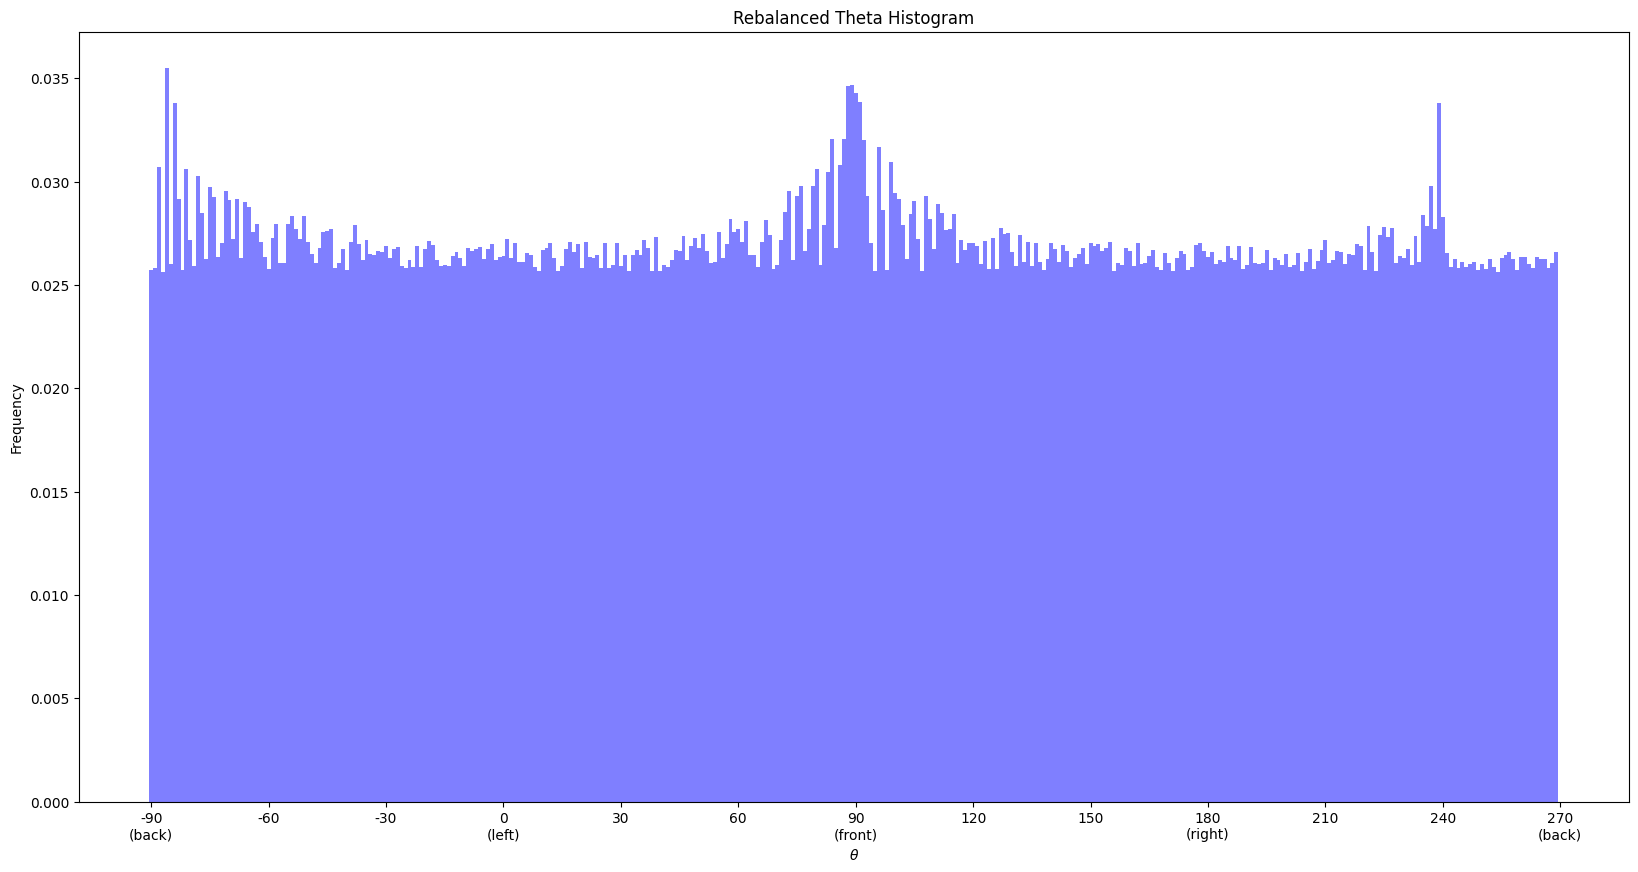

In [5]:
import math
theta_hist = np.histogram(theta, bins=360, density=True)
# calculate max and min frequency
max_freq = np.max(theta_hist[0])
min_freq = np.min(theta_hist[0])
new_probs = []
print(f'Max frequency: {max_freq}, Min frequency: {min_freq}; multiply: {max_freq/min_freq}')
dup_per_deg = {}
for _theta_prob, degree in zip(theta_hist[0], range(-90, 270)):
    new_probs.append(_theta_prob * math.ceil(max_freq/_theta_prob))
    if degree >= 180: degree -= 360
    dup_per_deg[degree] = math.ceil(max_freq/_theta_prob)
new_probs = np.array(new_probs)
# plot new histogram
fig, ax6 = plt.subplots(1, 1, figsize=(20, 10))
ax6.bar(range(-90, 270), new_probs, width=1.0, color='b', alpha=0.5)
ax6.set_xticks(np.arange(-90, 271, 30))
ax6.set_xticklabels(['-90\n(back)', '-60', '-30', '0\n(left)', '30', '60', '90\n(front)', '120', '150', '180\n(right)', '210', '240', '270\n(back)'])
ax6.set_xlabel(r"$\theta$")
ax6.set_ylabel("Frequency")
ax6.set_title("Rebalanced Theta Histogram")
plt.show()
with open('./temp/dup_per_deg.json', 'w') as f:
    json.dump(dup_per_deg, f, indent=4)


In [13]:
0.025640077538888008 // 0.000936906034249751

27.0